# Import

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import src.plot_data as plot_data
import pickle
import src.gaussian_process as gp
import src.tools as tools

import importlib
importlib.reload(plot_data)
importlib.reload(gp)

<module 'src.gaussian_process' from '/data/dev/ml_skyportal/src/gaussian_process.py'>

# load kowalski data

In [2]:
import os
import pandas as pd
from penquins import Kowalski
from tqdm import tqdm
import numpy as np
import dotenv

dotenv.load_dotenv()

True

In [69]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from penquins import Kowalski
import multiprocessing

# Constants
BASE_PATH = 'data_kowalski/'
DATA_PATH = 'BTS.csv'
BATCH_SIZE = 16
KOWALSKI_HOST = 'kowalski.caltech.edu'
KOWALSKI_PORT = 443

def ensure_directory_exists(path):
    """Ensure the base directory exists."""
    if not os.path.exists(path):
        try:
            os.makedirs(path)
            print(f"Created base directory: {path}")
        except PermissionError as e:
            print(f"Permission denied: {e}")
            exit()

def get_kowalski_instance():
    """Initialize and return a Kowalski instance."""
    kowalski_token = os.getenv("KOWALSKI_API_TOKEN")
    instances = {
        'kowalski': {
            'protocol': 'https',
            'port': KOWALSKI_PORT,
            'host': KOWALSKI_HOST,
            'token': kowalski_token
        }
    }
    return Kowalski(instances=instances)

def check_kowalski_connection(k):
    """Check the connection to Kowalski."""
    if k.ping(name="kowalski"):
        print("Connected to Kowalski")
    else:
        print("Unable to connect to Kowalski")
        exit()

def load_bts_data(data_path):
    """Load BTS data from a CSV file."""
    df_bts = pd.read_csv(data_path)
    return sorted(list(set(df_bts["ZTFID"])))

def divide_chunks(lst, n):
    """Divide a list into chunks of size n."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def create_queries(obj_id):
    """Create queries for a given object ID."""
    query_alerts = {
        "query_type": "find",
        "query": {
            "catalog": 'ZTF_alerts',
            "filter": {"objectId": obj_id},
            "projection": {
                "_id": 0,
                "objectId": 1,
                "candidate": 1,
                "cutoutScience": 1,
                "cutoutTemplate": 1,
                "cutoutDifference": 1,
            },
        },
    }
    query_alerts_aux = {
        "query_type": "find",
        "query": {
            "catalog": "ZTF_alerts_aux",
            "filter": {"_id": obj_id},
            "projection": {"prv_candidates": 1},
        },
    }
    return query_alerts, query_alerts_aux

def save_alerts(obj_id, data, base_path):
    """Save alerts data to a file."""
    objDirectory = os.path.join(base_path, obj_id)
    if not os.path.exists(objDirectory):
        os.makedirs(objDirectory)
    alertsFile = os.path.join(objDirectory, 'alerts.npy')
    np.save(alertsFile, data)

def save_aux_alerts(obj_id, data, base_path):
    """Save auxiliary alerts data to a CSV file."""
    objDirectory = os.path.join(base_path, obj_id)
    if not os.path.exists(objDirectory):
        os.makedirs(objDirectory)
    photo = data['prv_candidates']
    photo_df = pd.DataFrame(photo)
    photo_df['obj_id'] = obj_id
    photo_df.to_csv(os.path.join(objDirectory, 'photometry.csv'), index=False)

def process_responses(responses, base_path):
    """Process responses from Kowalski and save data."""
    for response in responses["kowalski"]:
        if response["status"] == "success":
            data = response["data"]
            if not data:
                continue
            if "objectId" in data[0]:
                obj_id = data[0]["objectId"]
                save_alerts(obj_id, data, base_path)
            elif "prv_candidates" in data[0]:
                obj_id = data[0]["_id"]
                save_aux_alerts(obj_id, data[0], base_path)

def is_object_processed(obj_id, base_path):
    """Check if the object has already been processed by looking for the files."""
    objDirectory = os.path.join(base_path, obj_id)
    alertsFile = os.path.join(objDirectory, 'alerts.npy')
    photometryFile = os.path.join(objDirectory, 'photometry.csv')
    return os.path.exists(alertsFile) and os.path.exists(photometryFile)

def main():
    ensure_directory_exists(BASE_PATH)
    k = get_kowalski_instance()
    check_kowalski_connection(k)

    objIds = load_bts_data(DATA_PATH)
    num_threads = multiprocessing.cpu_count() - 5
    print(f"Number of threads: {num_threads}")
    total_objects = len(objIds)
    print(f"Total number of objects: {total_objects}")

    batches = list(divide_chunks(objIds, BATCH_SIZE))

    for batch in tqdm(batches, desc="Processing batches"):
        queries = []

        for obj_id in batch:
            # if is_object_processed(obj_id, BASE_PATH):
            #     continue
            query_alerts, query_alerts_aux = create_queries(obj_id)
            queries.append(query_alerts)
            queries.append(query_alerts_aux)

        responses = k.query(queries=queries, use_batch_query=True, max_n_threads=num_threads)
        process_responses(responses, BASE_PATH)

In [70]:
main()

Connected to Kowalski
Number of threads: 27
Total number of objects: 14153


Processing batches: 100%|██████████| 885/885 [15:43<00:00,  1.07s/it] 


# Load

In [3]:
import plotly.graph_objects as go

def plot_gp(raw_df, gp_df):
    # Define the color dictionary
    color_dict = {'ztfg': 'rgba(0, 128, 0, 0.2)', 'ztfr': 'rgba(255, 0, 0, 0.2)', 'ztfi': 'rgba(255, 255, 0, 0.2)'}
    line_color_dict = {'ztfg': 'rgba(0, 128, 0, 1.0)', 'ztfr': 'rgba(255, 0, 0, 1.0)', 'ztfi': 'rgba(255, 255, 0, 1.0)'}

    fig = go.Figure()

    # Plot raw data points
    for filter_name in raw_df['filter'].unique():
        filter_data = raw_df[raw_df['filter'] == filter_name]
        fig.add_trace(go.Scatter(
            x=filter_data['mjd'],
            y=filter_data['flux'],
            mode='markers',
            name=f'Raw {filter_name}',
            marker=dict(color=line_color_dict[filter_name]),
            # error_y=dict(
            #     type='data',
            #     array=filter_data['flux_error'],
            #     visible=True
            # ),
            hovertemplate=(
                'mjd: %{x}<br>'
                'flux: %{y}<br>'
                # 'flux_error: %{marker.error_y.array}<br>'
                'filter: %{text}<br>'
                'obj_id: ' + filter_data['obj_id'].iloc[0]
            ),
            text=filter_data['filter']
        ))

    # Plot GP data with error bands
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        flux_col = f'flux_{filter_name}'
        error_col = f'flux_error_{filter_name}'
        
        fig.add_trace(go.Scatter(
            x=gp_df['mjd'],
            y=gp_df[flux_col],
            mode='lines',
            name=f'GP {filter_name}',
            line=dict(color=line_color_dict[filter_name])
        ))
        fig.add_trace(go.Scatter(
            x=gp_df['mjd'],
            y=gp_df[flux_col] + gp_df[error_col],
            mode='lines',
            line=dict(color=line_color_dict[filter_name].replace('1.0', '0')),
            showlegend=False,
            name=f'Upper Bound {filter_name}'
        ))
        fig.add_trace(go.Scatter(
            x=gp_df['mjd'],
            y=gp_df[flux_col] - gp_df[error_col],
            mode='lines',
            line=dict(color=line_color_dict[filter_name].replace('1.0', '0')),
            fill='tonexty',
            fillcolor=color_dict[filter_name],
            showlegend=False,
            name=f'Lower Bound {filter_name}'
        ))

    fig.update_layout(
        xaxis_title='Time (mjd)',
        yaxis_title='Flux',
        legend=dict(orientation='h')
    )

    if 'obj_id' in raw_df.columns:
        fig.update_layout(
            title=f'Light Curve for Object ID: {raw_df["obj_id"].iloc[0]}'
        )

    fig.show()

In [4]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

def plot_photometry(lc, color_dict=None):
    if color_dict is None:
        color_dict = {
            'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow',
            'sdssg': 'green', 'sdssr': 'red', 'sdssi': 'yellow',
            'atlasc': 'cyan', 'atlaso': 'orange'
        }
    
    fig = go.Figure()

    # Function to add trace to the figure
    def add_trace(data, name, color, symbol='circle', line_width=1, size=8, show_legend=True):
        fig.add_trace(go.Scatter(
            x=data['mjd'],
            y=data['mag'],
            error_y=dict(type='data', array=data['magerr'], visible=True),
            mode='markers',
            marker=dict(color=color, size=size, symbol=symbol, line=dict(width=line_width)),
            name=name,
            text=[
                f"MJD: {mjd}<br>Mag: {mag}<br>MagErr: {magerr}<br>SNR: {snr}" 
                for mjd, mag, magerr, snr in zip(data['mjd'], data['mag'], data['magerr'], data['snr'])
            ],
            legendgroup=name,
            showlegend=show_legend
        ))

    # Loop through each filter
    for f in lc['filter'].unique():
        filter_data = lc[lc['filter'] == f]
        
        detected = filter_data[filter_data['mag'] >= 3.0]
        upper_limits = filter_data[filter_data['snr'] < 3] if 'snr' in filter_data.columns else pd.DataFrame()
        
        add_trace(detected, f, color_dict[f])
        
        if not upper_limits.empty:
            upper_limits['mag'] = upper_limits['limiting_mag']  # Use limiting_mag for upper limits
            add_trace(upper_limits, f'{f} Upper Limits', color_dict[f], symbol='triangle-up-open', line_width=2, show_legend=False)

    fig.update_yaxes(autorange='reversed')
    fig.update_layout(
        title=f"{lc['obj_id'].iloc[0]} - {lc['type'].iloc[0]}",
        xaxis_title="MJD",
        yaxis_title="Magnitude (AB)",
        legend_title="Filter",
        hovermode='closest'
    )

    fig.show()

In [5]:
#list all the files name in the directory
import os
BASE_PATH = 'data_kowalski/'

list_name = os.listdir(BASE_PATH)
print(len(list_name))
print(list_name)

14153
['ZTF18abjijwk', 'ZTF21acoqbfm', 'ZTF20aaodhzr', 'ZTF20aafsnpp', 'ZTF21aaecjfc', 'ZTF23absjeqz', 'ZTF23abbanlv', 'ZTF20abmbxrq', 'ZTF18acbzpxx', 'ZTF22aamfjun', 'ZTF20abwdaeo', 'ZTF19aaptsxk', 'ZTF21aagofnn', 'ZTF21aaawwdt', 'ZTF21abuetwv', 'ZTF21acceboj', 'ZTF23aaawbmy', 'ZTF18abwerpm', 'ZTF19abegxob', 'ZTF20acbgacu', 'ZTF21aciqkxk', 'ZTF23aanbfab', 'ZTF20abfhzhm', 'ZTF20aazpxpy', 'ZTF21abbomrf', 'ZTF20abefeab', 'ZTF23aaxuvkn', 'ZTF19acjdwqv', 'ZTF20aapadwx', 'ZTF23aaeardk', 'ZTF21aatghue', 'ZTF19aakkwpb', 'ZTF22aafracj', 'ZTF21aarqkes', 'ZTF20acveyyv', 'ZTF20acgddbm', 'ZTF21aaaigfg', 'ZTF20acwxhka', 'ZTF18acvwcky', 'ZTF19abxequc', 'ZTF21abhshmt', 'ZTF22abkmrkh', 'ZTF19aangcrd', 'ZTF22aaaentm', 'ZTF22aacfhxo', 'ZTF23aaisxic', 'ZTF22absqjoo', 'ZTF20acumcrz', 'ZTF23aabkubg', 'ZTF19acgjtxu', 'ZTF23aaiyxwq', 'ZTF21abcmlzt', 'ZTF20aaiftgi', 'ZTF22aaavods', 'ZTF21acpytrp', 'ZTF24aaahxph', 'ZTF22abucnqf', 'ZTF20acuoatt', 'ZTF20abysxbk', 'ZTF23abbccir', 'ZTF20aaxzkfy', 'ZTF23aaqxlpn', '

In [6]:
def clean_photometry(df, df_type):
    # rename magpsf to mag
    df = df.rename(columns={'magpsf': 'mag'})
    # rename sigmapsf to magerr
    df = df.rename(columns={'sigmapsf': 'magerr'})
    # rename fid to filter
    df = df.rename(columns={'fid': 'filter'})
    df['filter'] = df['filter'].replace({1: 'ztfg', 2: 'ztfr', 3: 'ztfi'})

    # rename scorr to snr
    df = df.rename(columns={'scorr': 'snr'})

    # rename diffmaglim to limiting_mag
    df = df.rename(columns={'diffmaglim': 'limiting_mag'})

    # rename jd to mjd, mjd = jd - 2400000.5
    df['mjd'] = df['jd'] - 2400000.5
    
    df = df[['obj_id', 'jd', 'mjd', 'mag', 'magerr', 'snr', 'limiting_mag', 'filter']]

    df_type = df_type.rename(columns={'ZTFID': 'obj_id'})
    df = df.merge(df_type[['obj_id', 'type']], on='obj_id', how='left')

    df = df.dropna(subset=['mag', 'magerr'])
    df = df.reset_index(drop=True)

    return df

In [7]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

DATA_PATH = 'BTS.csv'
NUM_THREADS = multiprocessing.cpu_count() - 5
BASE_PATH = 'data_kowalski/'

def process_csv(name, df_bts):
    """Function to read and clean a single CSV file."""
    file_path = os.path.join(BASE_PATH, name, 'photometry.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = clean_photometry(df, df_bts)
        return df
    return pd.DataFrame()

def main(save=False):
    # Load BTS data
    df_bts = pd.read_csv(DATA_PATH)
    list_name = os.listdir(BASE_PATH)
    list_name = list_name[:3000]
    
    res_df = pd.DataFrame()

    # Use ThreadPoolExecutor to process CSV files in parallel
    with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        futures = {executor.submit(process_csv, name, df_bts): name for name in list_name}
        for future in tqdm(futures, total=len(futures), desc="Processing CSV files"):
            result = future.result()
            if not result.empty:
                res_df = pd.concat([res_df, result], ignore_index=True)

    # Optionally, save the concatenated result to a file
    if save:
        res_df.to_csv('combined_photometry.csv', index=False)

    return res_df

In [8]:
res_df = main(save=False)

Processing CSV files: 100%|██████████| 3000/3000 [02:43<00:00, 18.40it/s]


<Axes: xlabel='filter'>

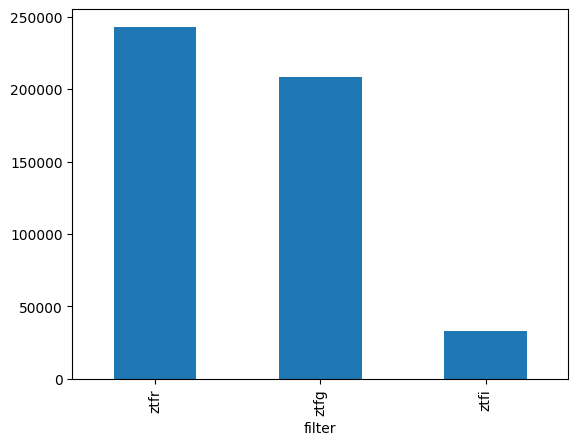

In [9]:
res_df['filter'].value_counts().plot(kind='bar')

# OK

In [8]:
from astropy.io import fits
import warnings
from astropy.utils.exceptions import AstropyWarning
import gzip
import io

def get_alerts(BASE_PATH, obj_id):
    alertsFile = os.path.join(BASE_PATH, obj_id, 'alerts.npy')
    object_alerts = np.load(alertsFile, allow_pickle=True)
    return object_alerts

def decompress_fits(data):
    compressed_data = gzip.decompress(data)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=AstropyWarning)
        with fits.open(io.BytesIO(compressed_data), ignore_missing_end=True) as hdul:
            return hdul[0].data

def process_alert(alert):
    # metadata
    metadata = alert['candidate']
    metadata_df = pd.DataFrame([metadata])
    metadata_df['obj_id'] = alert['objectId']

    # images
    cutout_science = decompress_fits(alert['cutoutScience']['stampData'])
    cutout_template = decompress_fits(alert['cutoutTemplate']['stampData'])
    cutout_difference = decompress_fits(alert['cutoutDifference']['stampData'])

    assembled_image = np.stack((cutout_science, cutout_template, cutout_difference), axis=-1)

    return metadata_df, assembled_image

def get_process_alerts(obj_id):
    object_alerts = get_alerts(BASE_PATH, obj_id)
    metadata_df = pd.DataFrame()
    images = []
    for alert in object_alerts:
        metadata_df_tmp, image = process_alert(alert)
        metadata_df = pd.concat([metadata_df, metadata_df_tmp], ignore_index=True)
        images.append(image)
    return metadata_df, images

In [72]:
obj_id = 'ZTF17aaaocnx'

# get one photometry
photo_df = process_csv(obj_id, pd.read_csv(DATA_PATH))

# get one metadata and images
metadata_df, images = get_process_alerts(obj_id)

100%|██████████| 45/45 [00:00<00:00, 146.33it/s]


In [73]:
photo_df.head()

,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF17aaaocnx,2.460154e+06,60153.486377,18.392099,0.081308,17.5838,19.760599,ztfr,-
1,ZTF17aaaocnx,2.460154e+06,60153.488808,18.335600,0.065222,16.2286,19.732800,ztfr,-
2,ZTF17aaaocnx,2.460154e+06,60153.491227,18.310400,0.096715,16.4280,19.641300,ztfr,-
3,ZTF17aaaocnx,2.460154e+06,60153.493657,18.312799,0.088877,18.7103,19.434299,ztfr,-
4,ZTF17aaaocnx,2.460154e+06,60153.496088,18.324400,0.105593,14.6675,19.202400,ztfr,-


In [74]:
metadata_df

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,obj_id,drb,drbversion
0,2.458585e+06,1,830201593615,19.657459,ztf_20190411201597_000745_zg_c10_o_q1_scimrefd...,Kulkarni,1,830201593615015011,t,11,...,0.511,0.201462,5.915524,36.367275,20.115913,11.215224,30.0,ZTF17aaaocnx,NaN,NaN
1,2.458588e+06,1,833181553615,19.259176,ztf_20190414181551_000745_zg_c10_o_q1_scimrefd...,Kulkarni,1,833181553615015002,t,2,...,0.502,0.191307,5.862937,36.481812,20.115913,11.215224,30.0,ZTF17aaaocnx,NaN,NaN
2,2.458593e+06,1,838145133615,19.259771,ztf_20190419145139_000745_zg_c10_o_q1_scimrefd...,Kulkarni,1,838145133615015005,t,5,...,0.502,0.194995,5.790637,36.670204,20.115913,11.215224,30.0,ZTF17aaaocnx,NaN,NaN
3,2.458593e+06,2,838218983615,19.095535,ztf_20190419218981_000745_zr_c10_o_q1_scimrefd...,Kulkarni,1,838218983615015006,t,6,...,0.518,0.202002,5.970756,36.574085,20.115913,11.215224,30.0,ZTF17aaaocnx,NaN,NaN
4,2.458854e+06,1,1099449203615,20.448132,ztf_20200105449201_000745_zg_c10_o_q1_scimrefd...,Kulkarni,1,1099449203615015023,t,23,...,0.517,0.202978,5.801733,36.437412,20.115913,11.215224,30.0,ZTF17aaaocnx,1.000000,d6_m7
5,2.458945e+06,2,1190166673615,19.740345,ztf_20200405166655_000745_zr_c10_o_q1_scimrefd...,Kulkarni,1,1190166673615015007,t,7,...,0.517,0.201471,5.873039,36.474369,20.115913,11.215224,30.0,ZTF17aaaocnx,1.000000,d6_m7
6,2.458945e+06,1,1190197303615,19.104633,ztf_20200405197292_000745_zg_c10_o_q1_scimrefd...,Kulkarni,1,1190197303615015015,t,15,...,0.485,0.183926,5.708218,36.740959,20.115913,11.215224,30.0,ZTF17aaaocnx,0.999990,d6_m7
7,2.459113e+06,2,1358498503615,20.620564,ztf_20200920498507_000745_zr_c10_o_q1_scimrefd...,Kulkarni,1,1358498503615015018,t,18,...,0.518,0.200723,5.772227,36.508572,20.115913,11.215224,30.0,ZTF17aaaocnx,0.999454,d6_m7
8,2.459115e+06,2,1360495193615,20.514149,ztf_20200922495197_000745_zr_c10_o_q1_scimrefd...,SRG,1,1360495193615015011,t,11,...,0.518,0.201684,5.742216,36.465065,20.115913,11.215224,30.0,ZTF17aaaocnx,1.000000,d6_m7
9,2.459115e+06,2,1360500393615,20.539602,ztf_20200922500394_000745_zr_c10_o_q1_scimrefd...,Kulkarni,1,1360500393615015019,t,19,...,0.518,0.201056,5.682046,36.454159,20.115913,11.215224,30.0,ZTF17aaaocnx,1.000000,d6_m7


In [9]:
def get_first_valid_index(photometry, object_alertes):
    for i, alert in enumerate(object_alertes):
        jd_current = alert['candidate']['jd']
        photometry_filtered = photometry[photometry['jd'] < jd_current]

        filters_to_check = ['ztfr', 'ztfg', 'ztfi']
        for filt in filters_to_check:
            if (photometry_filtered['filter'] == filt).sum() >= 3:
                return i
    
    return -1

def cut_photometry(photometry, object_alertes, index):
    jd_current = object_alertes[index]['candidate']['jd']
    photometry_filtered = photometry[photometry['jd'] < jd_current]
    return photometry_filtered

In [10]:
def cut_photometry(photo_df, metadata_df, index):
    jd_current = metadata_df['jd'].iloc[index]
    photometry_filtered = photo_df[photo_df['jd'] < jd_current]
    return photometry_filtered

In [77]:
len(metadata_df)

45

In [79]:
photo_filt = cut_photometry(photo_df, metadata_df, 44)
plot_photometry(photo_filt)

In [11]:
import pickle

with open('kernel.pkl', 'rb') as f:
    kernel = pickle.load(f)

In [11]:
def process_gp(photo_df):
    df_gp_ready = tools.Mag2Flux(photo_df)
    df_gp_ready = tools.Normalize_mjd(df_gp_ready)
    df_gp_ready = df_gp_ready.drop_duplicates()
    df_gp_ready = df_gp_ready.reset_index(drop=True)
    df_gp_ready = tools.robust_scale(df_gp_ready, ['flux', 'flux_error'])
    return df_gp_ready

In [81]:
gp_ready = process_gp(photo_filt)

gp_final = g.process_gaussian(gp_ready, kernel=kernel, number_gp=200)
gp_final['flux_error_ztfi'] = None
gp_final['flux_ztfi'] = None

100%|██████████| 1/1 [00:00<00:00, 34.66it/s]


In [82]:
plot_gp(gp_ready, gp_final)

In [12]:
def get_extreme_alerts(photo_df):
    photo_df = photo_df.sort_values(by='mjd')
    photo_df['mjd_diff'] = photo_df['mjd'].diff()
    photo_df['mjd_diff'] = photo_df['mjd_diff'].fillna(0)
    photo_df['mjd_diff'] = photo_df['mjd_diff'].apply(lambda x: 1 if x > 10 else 0)
    photo_df['mjd_diff'] = photo_df['mjd_diff'].cumsum()

    return photo_df

def obj_id_process(obj_id):
    photo_df = process_csv(obj_id, pd.read_csv(DATA_PATH))
    metadata_df, images = get_process_alerts(obj_id)
    
    print(photo_df['type'].iloc[0])

    if 'jd' not in metadata_df.columns:
        print(f'No alerts found for object ID: {obj_id}')
        return
    
    # # get photometry avant max_index
    # photo_filt = get_extreme_alerts(photo_df)
    # photo_filt['mjd_diff'].value_counts().plot(kind='bar')
    # max_index = photo_filt[photo_filt['mjd_diff'] == 0].index.max()

    # photo_df = photo_df[photo_df['jd'] <= photo_df['jd'].iloc[max_index]]

    print(len(metadata_df))
    photo_ready = cut_photometry(photo_df, metadata_df, len(metadata_df) - 1)
    gp_ready = process_gp(photo_ready)
    gp_final = g.process_gaussian(gp_ready, kernel=kernel, number_gp=200)

    if 'flux_ztfi' not in gp_final.columns:
        gp_final['flux_ztfi'] = None
        gp_final['flux_error_ztfi'] = None

    if 'flux_ztfg' not in gp_final.columns:
        gp_final['flux_ztfg'] = None
        gp_final['flux_error_ztfg'] = None

    if 'flux_ztfr' not in gp_final.columns:
        gp_final['flux_ztfr'] = None
        gp_final['flux_error_ztfr'] = None    

    plot_gp(gp_ready, gp_final)
    return photo_df

In [172]:
import random

obj_id = random.choice(list_name[:1000])
photo_df = obj_id_process(obj_id)

100%|██████████| 119/119 [00:00<00:00, 163.80it/s]


SN Ia
119


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


# DATALOADER

In [13]:
import matplotlib.pyplot as plt

def plot_types_distributions(data, form='bar', name_col='type'):

    if form not in ['bar', 'pie']:
        print('Invalid form, please choose between bar and pie')
        return
    
    count = data[name_col].value_counts()

    plt.figure(figsize=(10, 6))
    plt.title('Distribution of Types')
    plt.ylabel('Types')
    plt.xlabel('Count')

    if form == 'bar':
        count.plot(kind='bar')
        for i, v in enumerate(count):
            plt.text(i, v, str(v), ha='center', rotation=45, fontsize=10)
    else:
        count.plot(kind='pie', autopct='%1.1f%%', shadow=True)

    plt.show()

def count_obj_by_type(df, name_col='type'):
    obj_id_count_per_type = df.groupby(name_col)['obj_id'].nunique()
    print(obj_id_count_per_type)

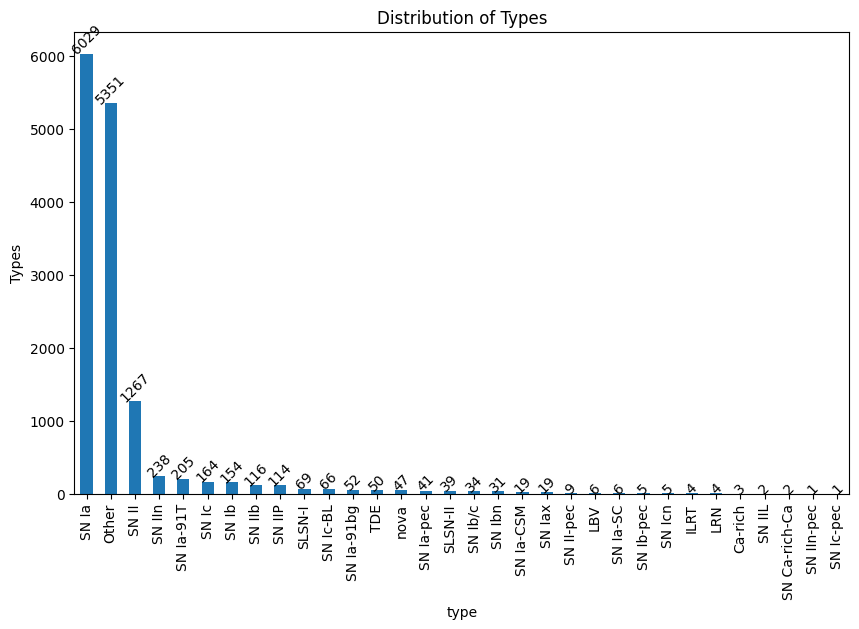

In [14]:
DATA_PATH = 'BTS.csv'

df_bts = pd.read_csv(DATA_PATH)
df_bts = df_bts.rename(columns={'ZTFID': 'obj_id'})
df_bts = df_bts[['obj_id', 'type']]
df_bts['type'] = df_bts['type'].apply(lambda x: 'Other' if x in ['-', 'other', 'Other'] else x)
plot_types_distributions(df_bts, form='bar', name_col='type')

In [15]:
def categorize_type_step1(event_type):
    if 'SN' in event_type:
        return 'SN'
    else:
        return 'Other'
    
def categorize_type_step2(event_type):
    if 'SN II' in event_type:
        return 'SN II'
    elif 'SN I' in event_type:
        return 'SN I'
    else:
        return 'Other'
    
def categorize_type_step3a(event_type):
    if 'SN Ia' in event_type:
        return 'SN Ia'
    elif 'SN Ib' in event_type:
        return 'SN Ib/c'
    elif 'SN Ic' in event_type:
        return'SN Ib/c'
    else:
        return 'Other'
    
def categorize_type_step3b(event_type):
    if 'SN IIn' in event_type:
        return 'SN IIn/b'
    elif 'SN IIb' in event_type:
        return 'SN IIn/b'
    elif 'SN II' in event_type:
        return'SN II'
    else:
        return 'Other'

In [16]:
df_bts['type_step1'] = df_bts['type'].apply(categorize_type_step1)
df_bts['type_step2'] = df_bts['type'].apply(categorize_type_step2)
df_bts['type_step3a'] = df_bts['type'].apply(categorize_type_step3a)
df_bts['type_step3b'] = df_bts['type'].apply(categorize_type_step3b)
df_bts

,obj_id,type,type_step1,type_step2,type_step3a,type_step3b
0,ZTF17aaaeqms,Other,Other,Other,Other,Other
1,ZTF17aaajowi,Other,Other,Other,Other,Other
2,ZTF17aaanztg,Other,Other,Other,Other,Other
3,ZTF17aaaocnx,Other,Other,Other,Other,Other
4,ZTF17aaaptxx,Other,Other,Other,Other,Other
...,...,...,...,...,...,...
14148,ZTF24aaguphd,Other,Other,Other,Other,Other
14149,ZTF24aagwfly,Other,Other,Other,Other,Other
14150,ZTF24aagwwkr,Other,Other,Other,Other,Other
14151,ZTF24aagzzye,Other,Other,Other,Other,Other


In [17]:
df_bts = df_bts[:15]
df_bts

,obj_id,type,type_step1,type_step2,type_step3a,type_step3b
0,ZTF17aaaeqms,Other,Other,Other,Other,Other
1,ZTF17aaajowi,Other,Other,Other,Other,Other
2,ZTF17aaanztg,Other,Other,Other,Other,Other
3,ZTF17aaaocnx,Other,Other,Other,Other,Other
4,ZTF17aaaptxx,Other,Other,Other,Other,Other
5,ZTF17aaapufz,LBV,Other,Other,Other,Other
6,ZTF17aaazdba,TDE,Other,Other,Other,Other
7,ZTF17aabgaoo,Other,Other,Other,Other,Other
8,ZTF17aabhmby,Other,Other,Other,Other,Other
9,ZTF17aabtvsy,SN Ia,SN,SN I,SN Ia,Other


In [18]:
def get_first_valid_index(photometry, metadata_df):
    for i, alert in enumerate(metadata_df.iterrows()):
        jd_current = metadata_df['jd'].iloc[i]
        photometry_filtered = photometry[photometry['jd'] < jd_current]

        filters_to_check = ['ztfr', 'ztfg', 'ztfi']
        for filt in filters_to_check:
            if (photometry_filtered['filter'] == filt).sum() >= 3:
                return i
    
    return -1

In [19]:
def process_gp(photo_df):
    df_gp_ready = tools.Mag2Flux(photo_df)
    df_gp_ready = tools.Normalize_mjd(df_gp_ready)
    df_gp_ready = df_gp_ready.drop_duplicates()
    df_gp_ready = df_gp_ready.reset_index(drop=True)
    df_gp_ready = tools.robust_scale(df_gp_ready, ['flux', 'flux_error'])
    return df_gp_ready

In [20]:
def cut_photometry(photo_df, metadata_df, index):
    jd_current = metadata_df['jd'].iloc[index]
    photometry_filtered = photo_df[photo_df['jd'] < jd_current]
    photo_processed = process_gp(photometry_filtered)
    if photo_processed['mjd'].max() > 365:
        return None
    return photo_processed

In [21]:
import multiprocessing
total_cpus = multiprocessing.cpu_count() - 5
print(total_cpus)

27


In [22]:
import torch
import multiprocessing

def normalize_images(images):
    min_val = images.min()
    max_val = images.max()
    normalized_images = 2 * (images - min_val) / (max_val - min_val) - 1
    return normalized_images

def preprocess_metadata(metadata_df):
    columns_metadata = [
        "sgscore1", "sgscore2", 
        "distpsnr1", "distpsnr2", 
        "fwhm", 
        "magpsf", 
        "sigmapsf", 
        "ra", 
        "dec", 
        "diffmaglim", 
        "ndethist", 
        "nmtchps", 
        "ncovhist", 
        "sharpnr", 
        "scorr", 
        "sky"
    ]
    metadata_df = metadata_df[columns_metadata]
    return metadata_df


def process_and_save_sample(args):
    sample, save_dir, kernel = args
    obj_id = sample['obj_id']
    alerte = sample['alerte']

    save_path = os.path.join(save_dir, f"{obj_id}_alert_{alerte}.npy")
    if os.path.exists(save_path):
        return

    gp_ready = sample['photometry']
    #gp_ready = process_gp(photo_df)
    
    gp_final = gp.process_gaussian(gp_ready, kernel=kernel, number_gp=200)

    if 'flux_ztfi' not in gp_final.columns:
        gp_final['flux_ztfi'] = None
        gp_final['flux_error_ztfi'] = None

    if 'flux_ztfg' not in gp_final.columns:
        gp_final['flux_ztfg'] = None
        gp_final['flux_error_ztfg'] = None

    if 'flux_ztfr' not in gp_final.columns:
        gp_final['flux_ztfr'] = None
        gp_final['flux_error_ztfr'] = None  

    sample['photometry'] = gp_ready
    sample['photo_gp'] = gp_final
    sample['metadata'] = preprocess_metadata(sample['metadata'])
    sample['images'] = normalize_images(sample['images'])

    np.save(save_path, sample)

def get_num_workers(reserved_cpus=5):
    total_cpus = multiprocessing.cpu_count()
    return max(1, total_cpus - reserved_cpus)

In [23]:
from torch.utils.data import Dataset, DataLoader

class SupernovaDataset(Dataset):
    def __init__(self, base_path, df_bts, save_dir, load_saved=True):
        self.base_path = base_path
        self.df_bts = df_bts
        self.kernel = None
        self.data = []
        self.save_dir = save_dir

        if load_saved and self.save_dir:
            self._load_saved_data()
        else:
            self._load_data()

    def load_kernel(self, kernel_path):
        with open(kernel_path, 'rb') as f:
            self.kernel = pickle.load(f)

    def _load_data(self):
        count = 0
        for idx, row in tqdm(self.df_bts.iterrows(), total=self.df_bts.shape[0], desc="Loading data"):
            obj_id = row['obj_id']
            target = row['type']            

            if any([obj_id in file for file in os.listdir(self.save_dir)]):
                continue

            photo_df = process_csv(obj_id, self.df_bts)
            metadata_df, images = get_process_alerts(obj_id)
        
            start_index = get_first_valid_index(photo_df, metadata_df)

            if start_index == -1:
                continue

            for i in range(start_index, len(metadata_df)):
                photo_ready = cut_photometry(photo_df, metadata_df, i)
                if photo_ready is None:
                    continue
                metadata_df_tmp = metadata_df.iloc[i]

                self.data.append({
                    'obj_id': obj_id,
                    'alerte': i,
                    'photometry': photo_ready,
                    'metadata': metadata_df_tmp,
                    'images': images[i],
                    'target': target
                })
        print(count)

    def _load_saved_data(self):
        self.data = []
        for file_name in tqdm(os.listdir(self.save_dir), desc="Loading saved data"):
            if file_name.endswith(".npy"):
                file_path = os.path.join(self.save_dir, file_name)
                sample = np.load(file_path, allow_pickle=True).item()
                self.data.append(sample)

    def preprocess_and_save(self):
        os.makedirs(self.save_dir, exist_ok=True)
        if self.kernel is None:
            self.load_kernel('kernel.pkl')
        
        args = [(sample, self.save_dir, self.kernel) for sample in self.data]

        num_workers = get_num_workers()

        with multiprocessing.Pool(num_workers) as pool:
            list(tqdm(pool.imap(process_and_save_sample, args), total=len(self.data), desc="Preprocessing"))
        
        self._load_saved_data()

    def plot_item(self, idx):
        sample = self.data[idx]
        print(sample['obj_id'])
        print(sample['target'])
        print(sample['alerte'])
        plot_gp(sample['photometry'], sample['photo_gp'])
        plot_data.plot_image(sample['images'])
        print(sample['metadata'])

    def plot_types_distributions(self, name_col='type'):
        plot_data.plot_types_distributions(self.df_bts, form='bar', name_col=name_col)

    def plot_alertes_types_distribution(self):
        type_counts = {}
        for sample in self.data:
            alert_type = sample['target']
            if alert_type not in type_counts:
                type_counts[alert_type] = 0
            type_counts[alert_type] += 1

        types = list(type_counts.keys())
        counts = list(type_counts.values())

        plt.figure(figsize=(10, 6))
        bars = plt.bar(types, counts)
        plt.xlabel('Type')
        plt.ylabel('Number of Alerts')
        plt.title('Distribution of Alert Types')

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', rotation=45)

        plt.show()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx]

In [24]:
BASE_PATH = 'data_kowalski/'

dataset = SupernovaDataset(BASE_PATH, df_bts, save_dir='data_preprocessed/', load_saved=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Loading saved data: 100%|██████████| 598/598 [00:00<00:00, 2064.01it/s]


In [25]:
dataloader.dataset.preprocess_and_save()

Loading saved data: 100%|██████████| 598/598 [00:00<00:00, 1823.46it/s]


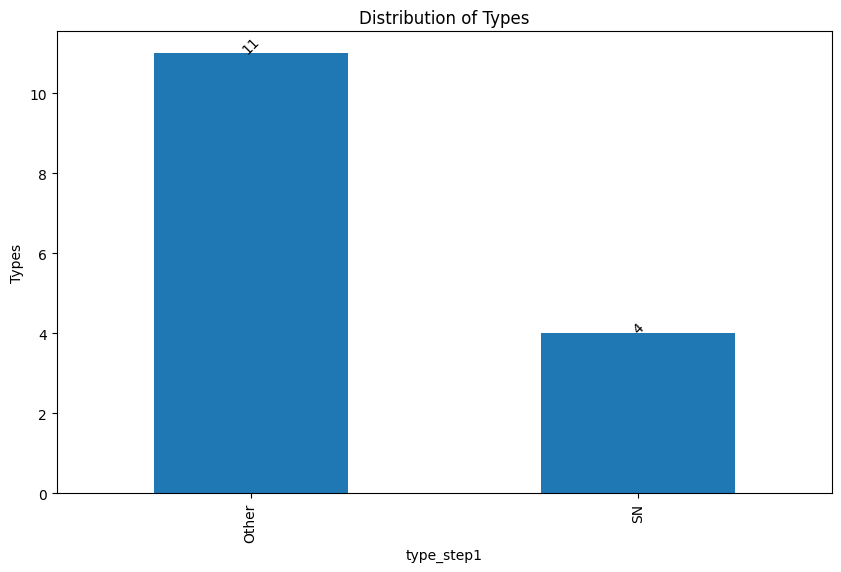

In [26]:
dataloader.dataset.plot_types_distributions(name_col='type_step1')

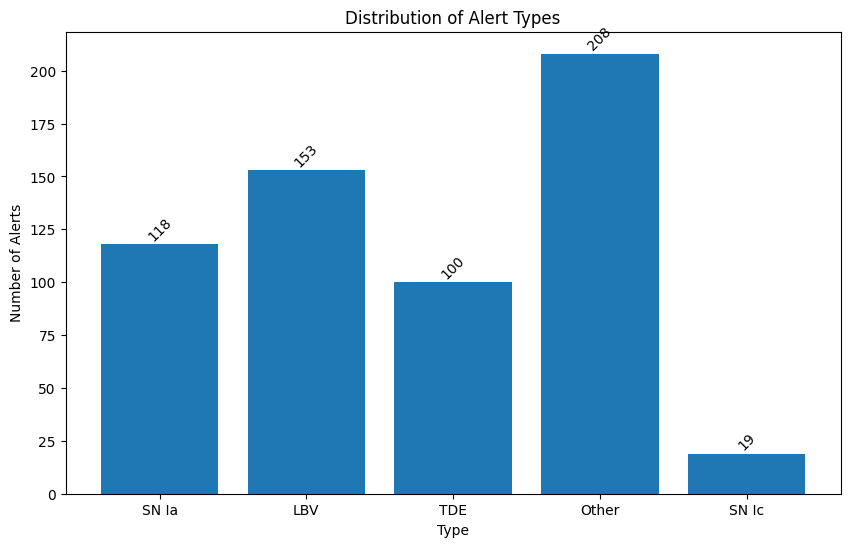

In [27]:
dataloader.dataset.plot_alertes_types_distribution()

In [28]:
len(dataloader.dataset)

598

In [29]:
# search ZTF17aabtvsy
for i, sample in enumerate(dataloader.dataset):
    if sample['obj_id'] == 'ZTF17aabtvsy':
        print(i)
        break

20


In [2]:
dataset.__getitem__(20)

NameError: name 'dataset' is not defined

ZTF17aaapufz
LBV
38


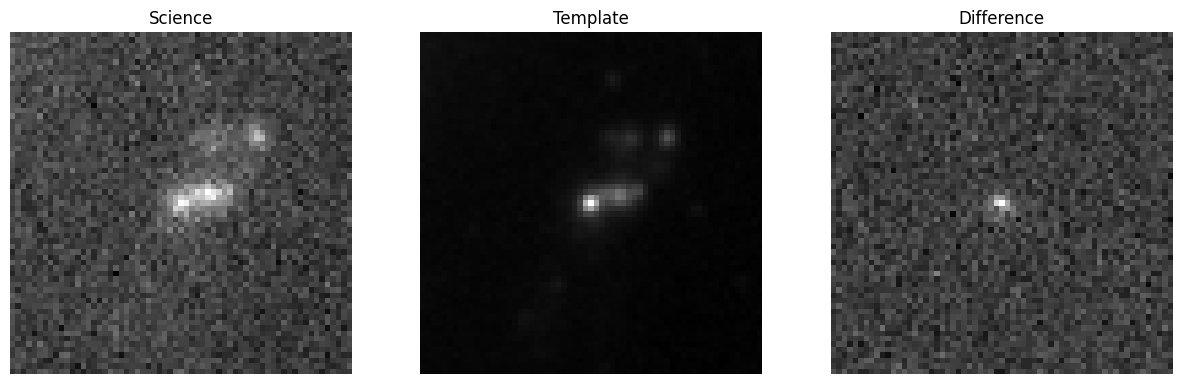

sgscore1         0.06775
sgscore2             0.5
distpsnr1       0.179197
distpsnr2       0.896678
fwhm                3.98
magpsf         18.793671
sigmapsf        0.054999
ra            188.967864
dec            27.932044
diffmaglim     19.872591
ndethist              40
nmtchps             19.0
ncovhist              64
sharpnr            0.173
scorr          14.498474
sky             0.075056
Name: 38, dtype: object


In [54]:
import random

id_alert = random.randint(0, len(dataloader.dataset))
dataloader.dataset.plot_item(id_alert)

# AFTER

In [42]:
# check les alertes extremes en fonction de mjd

def get_extreme_alerts(photo_df):
    photo_df = photo_df.sort_values(by='mjd')
    photo_df['mjd_diff'] = photo_df['mjd'].diff()
    photo_df['mjd_diff'] = photo_df['mjd_diff'].fillna(0)
    photo_df['mjd_diff'] = photo_df['mjd_diff'].apply(lambda x: 1 if x > 10 else 0)
    photo_df['mjd_diff'] = photo_df['mjd_diff'].cumsum()

    return photo_df

photo_filt = get_extreme_alerts(photo_df)

In [43]:
photo_filt

,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type,mjd_diff
38,ZTF19aawfbtg,2.458635e+06,58634.433426,20.422600,0.164636,9.70650,20.788700,ztfr,SLSN-I,0
39,ZTF19aawfbtg,2.458635e+06,58634.433426,20.422600,0.164636,9.70650,20.788700,ztfr,SLSN-I,0
40,ZTF19aawfbtg,2.458635e+06,58634.466319,20.379999,0.175666,11.52420,20.898100,ztfg,SLSN-I,0
41,ZTF19aawfbtg,2.458638e+06,58637.433611,20.025400,0.109686,14.79610,21.028200,ztfr,SLSN-I,0
44,ZTF19aawfbtg,2.458638e+06,58637.433611,20.025400,0.109686,14.79610,21.028200,ztfr,SLSN-I,0
...,...,...,...,...,...,...,...,...,...,...
26,ZTF19aawfbtg,2.460245e+06,60244.235984,19.787300,0.281221,6.99533,19.479799,ztfg,SLSN-I,7
27,ZTF19aawfbtg,2.460245e+06,60244.236458,19.848801,0.277278,5.74680,19.529600,ztfg,SLSN-I,7
28,ZTF19aawfbtg,2.460249e+06,60248.217188,19.891199,0.303433,5.63661,19.603800,ztfg,SLSN-I,7
29,ZTF19aawfbtg,2.460249e+06,60248.217188,19.891199,0.303433,5.63661,19.603800,ztfg,SLSN-I,7


<Axes: xlabel='mjd_diff'>

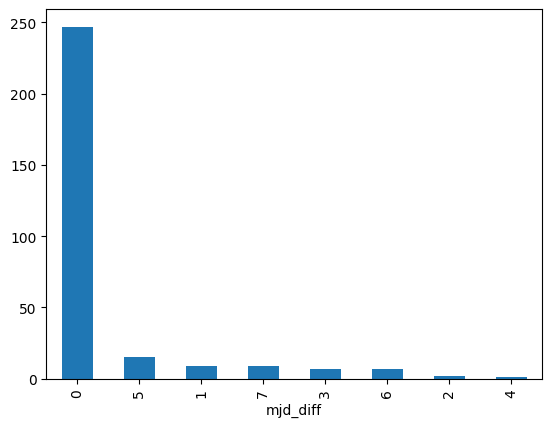

In [44]:
# plot les alertes extremes en fonction de mjd_diff
photo_filt['mjd_diff'].value_counts().plot(kind='bar')

In [53]:
# last alertes à mjd_diff = 0
photo_filt[photo_filt['mjd_diff'] == 0].index.max()

284

# NAN

In [5]:
clean_df = res_df[res_df['type'].str.contains('SN')]
obj_id_3filtres = clean_df.groupby('obj_id').filter(lambda x: len(x['filter'].unique()) == 3)['obj_id'].unique()
obj_id_3filtres_df = clean_df[clean_df['obj_id'].isin(obj_id_3filtres)]
print(len(obj_id_3filtres))

NameError: name 'res_df' is not defined

In [ ]:
# sort by nb_points
obj_id_3filtres_df['nb_points'] = obj_id_3filtres_df.groupby('obj_id')['obj_id'].transform('count')
obj_id_3filtres_df

/tmp/ipykernel_6124/2162452246.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type,nb_points
2496,ZTF17aacpbmv,2.460254e+06,60253.313345,18.673000,0.102377,19.35240,20.288099,ztfg,SN Ic,27
2497,ZTF17aacpbmv,2.460254e+06,60253.313345,18.673000,0.102377,19.35240,20.288099,ztfg,SN Ic,27
2498,ZTF17aacpbmv,2.460254e+06,60253.336609,18.726700,0.079100,8.02218,20.223101,ztfr,SN Ic,27
2499,ZTF17aacpbmv,2.460258e+06,60257.276157,18.068001,0.067679,23.81350,19.713900,ztfr,SN Ic,27
2500,ZTF17aacpbmv,2.460256e+06,60255.240382,18.441401,0.099680,11.61440,19.435499,ztfi,SN Ic,27
...,...,...,...,...,...,...,...,...,...,...
484239,ZTF19abwnpus,2.458782e+06,58781.242755,19.341000,0.224203,8.36609,19.306601,ztfr,SN Ia,29
484240,ZTF19abwnpus,2.458786e+06,58785.219595,20.581499,0.305647,6.53067,20.363600,ztfg,SN Ia,29
484241,ZTF19abwnpus,2.458786e+06,58785.219595,20.581499,0.305647,6.53067,20.363600,ztfg,SN Ia,29
484242,ZTF19abwnpus,2.458786e+06,58785.243553,19.719700,0.164553,10.52160,20.024300,ztfr,SN Ia,29


In [167]:
# garder les objets entre 500 et 1500
obj_id_3filtres_df = obj_id_3filtres_df[(obj_id_3filtres_df['nb_points'] >= 350) & (obj_id_3filtres_df['nb_points'] <= 380)]
print(len(obj_id_3filtres_df['obj_id'].unique()))

17


In [168]:
obj_id_3filtres_df = obj_id_3filtres_df.drop(columns=['nb_points'])
obj_id_3filtres_df = obj_id_3filtres_df.reset_index(drop=True)
obj_id_3filtres_df

,obj_id,jd,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF18aaqqoqs,2.459791e+06,59790.197268,20.009701,0.288005,5.78313,19.639999,ztfi,SN Ia-91T
1,ZTF18aaqqoqs,2.459318e+06,59317.303310,20.218000,0.322559,6.67348,19.958700,ztfi,SN Ia-91T
2,ZTF18aaqqoqs,2.459322e+06,59321.330359,19.944500,0.191654,10.12180,20.038300,ztfi,SN Ia-91T
3,ZTF18aaqqoqs,2.459326e+06,59325.245556,20.101601,0.252315,7.32203,19.984100,ztfi,SN Ia-91T
4,ZTF18aaqqoqs,2.459335e+06,59334.306366,20.105400,0.288262,7.36561,19.922899,ztfi,SN Ia-91T
...,...,...,...,...,...,...,...,...,...
6180,ZTF19abwaohs,2.458793e+06,58792.127257,19.599400,0.154827,10.70030,20.007900,ztfr,SN Ia
6181,ZTF19abwaohs,2.458794e+06,58793.094132,19.551001,0.180897,8.39252,19.667500,ztfr,SN Ia
6182,ZTF19abwaohs,2.458796e+06,58795.094595,19.856600,0.245317,8.33481,20.004801,ztfr,SN Ia
6183,ZTF19abwaohs,2.458796e+06,58795.094595,19.856600,0.245317,8.33481,20.004801,ztfr,SN Ia


In [158]:
import src.preprocessing.gaussian_process as g
import src.preprocessing.preprocessing_run as pr
import src.preprocessing.tools as tools

import importlib

importlib.reload(g)
importlib.reload(pr)

<module 'src.preprocessing.preprocessing_run' from '/home/theob/Documents/stage/ML_skyportal/src/preprocessing/preprocessing_run.py'>

In [170]:
df_gp_ready = tools.Mag2Flux(obj_id_3filtres_df)
df_gp_ready = tools.Normalize_mjd(df_gp_ready)
df_gp_ready = df_gp_ready.drop_duplicates()
df_gp_ready = df_gp_ready.reset_index(drop=True)
df_gp_ready = tools.robust_scale(df_gp_ready, ['flux', 'flux_error'])
df_gp_ready

,obj_id,mjd,flux,flux_error,filter,type
0,ZTF18aaqqoqs,1545.974815,-0.484529,0.101842,ztfi,SN Ia-91T
1,ZTF18aaqqoqs,1073.080857,-0.558493,-0.034433,ztfi,SN Ia-91T
2,ZTF18aaqqoqs,1077.107905,-0.458305,-0.427400,ztfi,SN Ia-91T
3,ZTF18aaqqoqs,1081.023102,-0.518916,-0.249994,ztfi,SN Ia-91T
4,ZTF18aaqqoqs,1090.083912,-0.520276,-0.048892,ztfi,SN Ia-91T
...,...,...,...,...,...,...
3985,ZTF19abwaohs,64.951875,-0.369441,0.130293,ztfr,SN Ia
3986,ZTF19abwaohs,64.950498,-0.289960,-0.287019,ztfr,SN Ia
3987,ZTF19abwaohs,65.917373,-0.261777,0.026652,ztfr,SN Ia
3988,ZTF19abwaohs,67.917836,-0.420366,0.067153,ztfr,SN Ia


In [171]:
kernel, suite_df = g.fit_2d_gp(df_gp_ready, return_kernel=True)
# save the kernel to a pickle file
import pickle

with open('kernel.pkl', 'wb') as f:
    pickle.dump(kernel, f)

In [119]:
# load the kernel from the pickle file
import pickle

with open('kernel.pkl', 'rb') as f:
    kernel = pickle.load(f)

In [222]:
gp_final = g.process_gaussian(df_gp_ready, kernel=kernel, number_gp=200)

100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


In [223]:
gp_final

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,-0.290714,-0.263975,-0.324616,0.217282,0.263123,0.204791,SN Ia-91T,ZTF18aaqqoqs
1,7.768718,0.188103,0.134207,0.149200,0.158521,0.211818,0.134909,SN Ia-91T,ZTF18aaqqoqs
2,15.537435,0.740304,0.606897,0.740629,0.135308,0.187714,0.112901,SN Ia-91T,ZTF18aaqqoqs
3,23.306153,0.718137,0.686783,0.787397,0.091506,0.159526,0.052267,SN Ia-91T,ZTF18aaqqoqs
4,31.074871,0.269505,0.395706,0.355221,0.123298,0.187781,0.113030,SN Ia-91T,ZTF18aaqqoqs
...,...,...,...,...,...,...,...,...,...
3395,68.516648,-0.693977,-0.245910,-0.370739,0.497137,0.533380,0.065092,SN Ia,ZTF19abwaohs
3396,68.868016,-0.694918,-0.253589,-0.385084,0.504033,0.537070,0.075556,SN Ia,ZTF19abwaohs
3397,69.219383,-0.696029,-0.261425,-0.399051,0.510999,0.540990,0.087172,SN Ia,ZTF19abwaohs
3398,69.570751,-0.697292,-0.269394,-0.412561,0.518058,0.545161,0.099860,SN Ia,ZTF19abwaohs


In [257]:
import random

random_obj_id = random.choice(gp_final['obj_id'].unique())
print(random_obj_id)

ZTF18aazabmh


In [219]:
# print type de l'objet
print(gp_final[gp_final['obj_id'] == random_obj_id]['type'].iloc[0])

SN Ia


In [220]:
one_raw = df_gp_ready[df_gp_ready['obj_id'] == random_obj_id]
one_gp = gp_final[gp_final['obj_id'] == random_obj_id]

In [221]:
plot_gp(one_raw, one_gp)

In [258]:
obj_id = 'ZTF19abwaohs'
one_raw = df_gp_ready[df_gp_ready['obj_id'] == obj_id]
one_gp = gp_final[gp_final['obj_id'] == obj_id]

plot_gp(one_raw, one_gp)

In [227]:
# test new kernel

kernel, suite_df = g.fit_2d_gp(df_gp_ready, return_kernel=True)
gp_final = g.process_gaussian(df_gp_ready, kernel=kernel, number_gp=200)

one_gp = gp_final[gp_final['obj_id'] == obj_id]
plot_gp(one_raw, one_gp)

100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


In [231]:
one_raw = one_raw.sort_values('mjd')
one_raw

,obj_id,mjd,flux,flux_error,filter,type
1476,ZTF18aazabmh,0.000000,-0.660724,-0.906154,ztfr,SN Ia
1477,ZTF18aazabmh,1.955625,-0.600859,-0.812799,ztfr,SN Ia
1478,ZTF18aazabmh,1.981088,-0.597443,-0.846490,ztfr,SN Ia
1479,ZTF18aazabmh,1.982002,-0.590760,-0.868174,ztfr,SN Ia
1480,ZTF18aazabmh,2.001412,-0.533204,-0.889365,ztfr,SN Ia
...,...,...,...,...,...,...
1689,ZTF18aazabmh,859.793692,-0.598129,-0.508250,ztfi,SN Ia
1690,ZTF18aazabmh,861.834769,-0.611567,-0.443515,ztfi,SN Ia
1475,ZTF18aazabmh,1450.100394,-0.603368,-0.488281,ztfi,SN Ia
1474,ZTF18aazabmh,1803.058194,-0.593323,-0.605233,ztfi,SN Ia


In [253]:
importlib.reload(g)

<module 'src.preprocessing.gaussian_process' from '/home/theob/Documents/stage/ML_skyportal/src/preprocessing/gaussian_process.py'>

In [260]:
# test new kernel

obj_id = 'ZTF18aaqqoqs'
one_raw = df_gp_ready[df_gp_ready['obj_id'] == obj_id]
one_gp = gp_final[gp_final['obj_id'] == obj_id]

kernel, suite_df = g.fit_2d_gp(one_raw, return_kernel=True)
gp_final = g.process_gaussian(one_raw, kernel=kernel, number_gp=200)

one_gp = gp_final[gp_final['obj_id'] == obj_id]
plot_gp(one_raw, one_gp)

100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


In [247]:
one_gp

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,-0.258349,-0.253179,-0.296267,0.184850,0.237342,0.179149,SN Ia,ZTF18aazabmh
1,10.964746,0.283970,0.169443,0.241021,0.038345,0.150661,0.056096,SN Ia,ZTF18aazabmh
2,21.929492,0.018269,0.245331,0.185712,0.044320,0.138662,0.047252,SN Ia,ZTF18aazabmh
3,32.894238,-0.462946,-0.024981,-0.181496,0.090823,0.141323,0.018113,SN Ia,ZTF18aazabmh
4,43.858984,-0.644260,-0.349934,-0.516705,0.158592,0.173853,0.084089,SN Ia,ZTF18aazabmh
...,...,...,...,...,...,...,...,...,...
195,2138.125483,-0.052228,-0.057271,-0.056035,0.468309,0.467671,0.467833,SN Ia,ZTF18aazabmh
196,2149.090229,-0.093993,-0.105240,-0.102445,0.461204,0.458569,0.459253,SN Ia,ZTF18aazabmh
197,2160.054975,-0.157848,-0.182519,-0.176222,0.441946,0.431550,0.434371,SN Ia,ZTF18aazabmh
198,2171.019722,-0.234645,-0.285969,-0.272025,0.403382,0.365813,0.377139,SN Ia,ZTF18aazabmh


In [241]:
one_gp

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,-0.258349,-0.253180,-0.296268,0.184850,0.237343,0.179149,SN Ia,ZTF18aazabmh
1,10.964746,0.283970,0.169443,0.241021,0.038345,0.150662,0.056096,SN Ia,ZTF18aazabmh
2,21.929492,0.018269,0.245330,0.185712,0.044320,0.138663,0.047252,SN Ia,ZTF18aazabmh
3,32.894238,-0.462947,-0.024981,-0.181496,0.090823,0.141324,0.018113,SN Ia,ZTF18aazabmh
4,43.858984,-0.644262,-0.349933,-0.516705,0.158592,0.173854,0.084089,SN Ia,ZTF18aazabmh
...,...,...,...,...,...,...,...,...,...
195,2138.125483,-0.052230,-0.057272,-0.056037,0.468313,0.467675,0.467836,SN Ia,ZTF18aazabmh
196,2149.090229,-0.093995,-0.105242,-0.102447,0.461207,0.458572,0.459256,SN Ia,ZTF18aazabmh
197,2160.054975,-0.157850,-0.182521,-0.176225,0.441949,0.431552,0.434373,SN Ia,ZTF18aazabmh
198,2171.019722,-0.234647,-0.285971,-0.272027,0.403384,0.365814,0.377141,SN Ia,ZTF18aazabmh


# Plot

# Filter points

# Mag2Flux and NormMjd

# Train GP Kernel

# Gaussian Process

# Norm Flux

# Mask

# Model